# Exercise 14 - Solution 

Use the SINDy algorthim as presented in the lecture on a Rössler system. The Rössler system is a three-dimensional chaotic dynamical system given by the governing equations: 
$$\frac{dx}{dt} = -y-z \\
\frac{dy}{dt} = x + ay \\ 
\frac{dz}{dt} = b + z(x - c),$$
with the most common parameter choices $a=0.1$, $b=0.1$, $c=14$. The Rössler system was set up by Otto Rössler to be a "minimal" chaotic system, as it is a three dimensional system with only nonlinearity. It was later found to be usefull for modelling certain chemical reactions as well. 

* Generate training data from the known Rössler system with `DifferentialEquations.jl` or `DynamicalSystems.jl`
* Use the training data for SINDy, to investigate if the algorithm can recover the governing equations correctly with the help of `DataDrivenDiffEq.jl` 
* How long, i.e. how much, training data do you need for the SINDy algorithm to sucussfully fit the Rössler equation? 

First, we are going to generate the training data. We'll integrate a very long trajectory

In [1]:
using Pkg
Pkg.activate(; temp = true)
Pkg.add("OrdinaryDiffEq")
Pkg.add("DataDrivenDiffEq")
Pkg.add("DataDrivenSparse")
Pkg.add("Flux")
Pkg.add("Zygote")
Pkg.add("Optimisers")
Pkg.add("SciMLSensitivity")
Pkg.add("SymbolicRegression")
Pkg.add("Plots")

  Activating new project at `/var/folders/vh/kv_4zdr96jz7s12j89cjcl780000gn/T/jl_3jHHbV`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `/private/var/folders/vh/kv_4zdr96jz7s12j89cjcl780000gn/T/jl_3jHHbV/Project.toml`
  [1dea7af3] + OrdinaryDiffEq v6.41.0
    Updating `/private/var/folders/vh/kv_4zdr96jz7s12j89cjcl780000gn/T/jl_3jHHbV/Manifest.toml`
  [79e6a3ab] + Adapt v3.5.0
  [ec485272] + ArnoldiMethod v0.2.0
  [4fba245c] + ArrayInterface v6.0.25
  [30b0a656] + ArrayInterfaceCore v0.1.29
  [6ba088a2] + ArrayInterfaceGPUArrays v0.2.2
  [015c0d05] + ArrayInterfaceOffsetArrays v0.1.7
  [b0d46f97] + ArrayInterfaceStaticArrays v0.1.5
  [dd5226c6] + ArrayInterfaceStaticArraysCore v0.1.3
  [62783981] + BitTwiddlingConvenienceFunctions v0.1.5
  [2a0fbf3d] + CPUSummary v0.2.2
  [49dc2e85] + Calculus v0.5.1
  [d360d2e6] + ChainRulesCore v1.15.7
  [9e997f8a] + ChangesOfVariables v0.1.5
  [fb6a15b2] + CloseOpenIntervals v0.1.11
  [38540

In [2]:
using OrdinaryDiffEq, Plots

function roessler(u, p, t)
    a, b, c = p 
    x, y, z = u
    return [-y-z,
    x + a*y,
    b + z*(x-c)]
end 

p = [0.1, 0.1, 14.]
x0 = rand(3)

prob = ODEProblem(roessler, x0, (0.,1000.), p)
sol = solve(prob, Tsit5(),saveat=0.1)


retcode: Success
Interpolation: 1st order linear
t: 10001-element Vector{Float64}:
    0.0
    0.1
    0.2
    0.3
    0.4
    0.5
    0.6
    0.7
    0.8
    0.9
    1.0
    1.1
    1.2
    ⋮
  998.9
  999.0
  999.1
  999.2
  999.3
  999.4
  999.5
  999.6
  999.7
  999.8
  999.9
 1000.0
u: 10001-element Vector{Vector{Float64}}:
 [0.7219050058371199, 0.0792760771754577, 0.7331055925356446]
 [0.6695401147843014, 0.14962268900051004, 0.19925812190481645]
 [0.639858873335171, 0.21686859407000522, 0.0579790359317006]
 [0.611366473623877, 0.28194986352898627, 0.020733777466520525]
 [0.5785382480488666, 0.3446244867251093, 0.010932561572213853]
 [0.5401260925548611, 0.40435297968879974, 0.00834998764095159]
 [0.49605647175901646, 0.4605360248398409, 0.0076577703576034585]
 [0.44660976541520675, 0.512581832103739, 0.007458373169273015]
 [0.3922011200060812, 0.5599284724488358, 0.007385581337423565]
 [0.3333200689761192, 0.6020540777933395, 0.007343959093090219]
 [0.27051126361004885, 0.638483

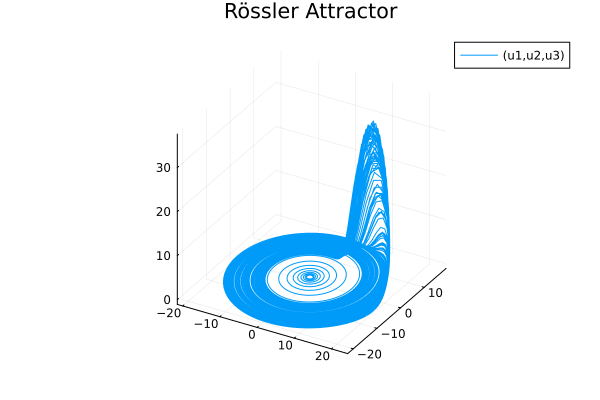

In [3]:
plot(sol, idxs=(1,2,3), title="Rössler Attractor")

We see the typical shape of the Rössler attractor!

Now, let's use this data as training data for SINDy.

In [11]:
using DataDrivenDiffEq, DataDrivenSparse

function train_SINDy(prob, N_t, Δt=0.1, Ttr=10.)
    
    t_saveat = Ttr:Δt:(Ttr+N_t*Δt)
    sol = solve(remake(prob; tspan=(0.,t_saveat[end])), Tsit5(), saveat=t_saveat)
    
    ddprob = DataDrivenProblem(sol)
    
    @variables t x(t) y(t) z(t)  # Symbolic variables
    u = [x, y, z]
    basis = Basis(polynomial_basis(u, 5), u, iv = t)
     
    optimiser = STLSQ(exp10.(-5:0.1:-1))

    solve(ddprob, basis, optimiser, options = DataDrivenCommonOptions(digits = 2))
end 

train_SINDy (generic function with 3 methods)

Let's test it first with 5000 data points: 

In [18]:
sol = train_SINDy(prob, 10000)

"DataDrivenSolution{Float64}"

In [19]:
sol.basis

Model ##Basis#365 with 3 equations
States (3):
  x(t)
  y(t)
  z(t)
Parameters (7):
  p₁
  p₂
  p₃
  p₄
  p₅
  p₆
⋮

In [20]:
sol.prob.p

7-element Vector{Float64}:
  -1.0
  -0.99
   1.0
   0.1
   0.1
 -13.99
   1.0

So, for 5000 data points it works very well! We'll try to test when SINDy finds the right functional form by computing the fit for different values of $N_t$ and checking if we still return exactly seven parameters. Then we will inspect the actual parameter values around that point! 

In [39]:
for N_t = 500:-10:10 
    
    sol = train_SINDy(prob, N_t)
    
    if length(sol.prob.p) != 7 
        println("Parameter set not valid at N_t=",N_t)
        break
    end 
end 

Parameter set not valid at N_t=20


In [41]:
for N_t = 50:-1:10 
    
    sol = train_SINDy(prob, N_t)
    
    if length(sol.prob.p) != 7 
        println("Parameter set not valid at N_t=",N_t)
        break
    end 
end 

Parameter set not valid at N_t=29


In [42]:
sol = train_SINDy(prob, 30); 
sol.basis


Model ##Basis#1061 with 3 equations
States (3):
  x(t)
  y(t)
  z(t)
Parameters (7):
  p₁
  p₂
  p₃
  p₄
  p₅
  p₆
⋮

In [43]:
sol.prob.p

7-element Vector{Float64}:
  -0.99
  -1.0
   0.99
   0.09
   0.09
 -13.99
   0.99

In [44]:
sol = train_SINDy(prob, 29); 
sol.basis

Model ##Basis#1069 with 3 equations
States (3):
  x(t)
  y(t)
  z(t)
Parameters (53):
  p₁
  p₂
  p₃
  p₄
  p₅
  p₆
⋮

In [45]:
sol.prob.p

53-element Vector{Float64}:
 -1.0
 -1.0
  1.0
  0.1
  0.54
  0.5
 -0.64
 -0.62
  0.24
  0.17
 -0.64
 -0.11
  0.9
  ⋮
  0.38
  0.32
  0.36
 -0.68
 -0.16
 -0.09
  0.68
  0.19
 -0.85
  0.01
 -0.01
  0.01

So in this case, the SINDy algorithm is still able to find the rhs for 30 data points, but fails for 29. 